In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn import svm

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
#import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

In [4]:
fn_gaia_all = '../data/gaia_slim_xsdss.fits'
tab_gaia_all = utils.load_table(fn_gaia_all)
N_data_all = len(tab_gaia_all)
print(f"Number of data sources: {N_data_all}")

Number of data sources: 6649162


In [5]:
fn_gaia_purer = '/scratch/ksf293/gaia-quasars-lss/data/gaia_purer.fits'
tab_gaia_purer = utils.load_table(fn_gaia_purer)
print(len(tab_gaia_purer))
print(tab_gaia_purer.columns)

1942825
<TableColumns names=('solution_id','source_id','astrometric_selection_flag','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','structure_function_index','structure_function_index_scatter','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','ccfratio_qsoc','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','sersic_index','sersic_index_error','ellipticity_hostgalaxy','ellipticity_hostgalaxy_error','posangle_hostgalaxy','posangle_hostgalaxy_error','host_galaxy_detected','l2_norm','morph_params_corr_vec','host_galaxy_flag','source_selection_flags')>


In [6]:
cols_tokeep = ['source_id', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
               'w1mpro', 'w2mpro']
tab_gaia_all_lite = tab_gaia_all.copy()
tab_gaia_all_lite.keep_columns(cols_tokeep)

In [7]:
tab_gaia_purer = astropy.table.join(tab_gaia_purer, tab_gaia_all_lite, keys='source_id', metadata_conflicts='silent')

In [8]:
tab_gaia_purer.columns

<TableColumns names=('solution_id','source_id','astrometric_selection_flag','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','structure_function_index','structure_function_index_scatter','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','ccfratio_qsoc','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','sersic_index','sersic_index_error','ellipticity_hostgalaxy','ellipticity_hostgalaxy_error','posangle_hostgalaxy','posangle_hostgalaxy_error','host_galaxy_detected','l2_norm','morph_params_corr_vec','host_galaxy_flag','source_selection_flags','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','w1mpro','w2mpro')>

In [9]:
tab_clean = utils.load_table(f'../data/gaia_clean.fits')
len(tab_clean)

1451214

In [10]:
G_max_Glim = 20.4
tab_Glim = utils.load_table(f'../data/gaia_G{G_max_Glim}.fits')
len(tab_Glim)

1001557

In [12]:
tab_Glim.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm','redshift_spz','redshift_sdss')>

In [11]:
G_max_Gclean = 20.0
tab_Gclean = utils.load_table(f'../data/gaia_G{G_max_Gclean}.fits')
len(tab_Gclean)

648842

### make no-qsoc no-mag sample

In [15]:
i_has_qsoc = np.isfinite(tab_gaia_all['redshift_qsoc'])
print(f'N with QSOC redshifts: {np.sum(i_has_qsoc)}')

N with QSOC redshifts: 6375063


In [16]:
print(np.max(tab_gaia_all['redshift_qsoc']), np.min(tab_gaia_all['redshift_qsoc']))

6.1294537 0.08266388


In [17]:
col_names_necessary = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'w1mpro', 'w2mpro']
cols_necessary = []
for col_name in col_names_necessary:
    cols_necessary.append(tab_gaia_all[col_name])
cols_necessary = np.array(cols_necessary).T
i_has_necessary = np.all(np.isfinite(cols_necessary), axis=1)
print(f"Has necessary color data: {np.sum(i_has_necessary)} ({np.sum(i_has_necessary)/len(i_has_necessary):.3f})")

Has necessary color data: 1706815 (0.257)


In [18]:
print("Has QSOC and color:", np.sum(i_has_qsoc & i_has_necessary))

Has QSOC and color: 1555108


In [19]:
tab_gaia_nec = tab_gaia_all[i_has_qsoc & i_has_necessary]
print(len(tab_gaia_nec))

1555108


## Load in labeled data

In [20]:
fn_sdss = '../data/sdss_xgaia_wise_good.fits.gz'
tab_sdss = Table.read(fn_sdss, format='fits')
print(len(tab_sdss))
print(tab_sdss.columns)

379741
<TableColumns names=('ra','dec','source_id','raj2000','dej2000','objid','sdss','thingid','z','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs','allwise_oid','w1mpro','w2mpro','ZWARNING','OBJID')>


In [21]:
i_sdss_haswise = np.isfinite(tab_sdss['w1mpro'])
print(np.sum(i_sdss_haswise))
i_sdss_hasg = np.isfinite(tab_sdss['phot_g_mean_mag'])
print(np.sum(i_sdss_hasg))
i_sdss_hasbp = np.isfinite(tab_sdss['phot_bp_mean_mag'])
print(np.sum(i_sdss_hasbp))

297965
379741
379741


In [22]:
fn_stars = '../data/stars_gaia_720k.fits.gz'
tab_stars = utils.load_table(fn_stars)
N_stars = len(tab_stars)
print(f"Number of stars: {N_stars}")
print(tab_stars.columns)

Number of stars: 720000
<TableColumns names=('ra','dec','source_id','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','allwise_oid','w1mpro','w2mpro')>


In [23]:
i_stars_haswise = np.isfinite(tab_stars['w1mpro'])
print(np.sum(i_stars_haswise))
i_in_q_all = np.isin(tab_stars['source_id'], tab_gaia_all['source_id'])
print(np.sum(i_in_q_all))
print(np.sum(i_in_q_all & i_stars_haswise))

129261
2666
677


In [24]:
fn_stars_sdss = '../data/stars_sdss_xgaia.fits.gz'
tab_stars_sdss = utils.load_table(fn_stars_sdss)
N_stars_sdss = len(tab_stars_sdss)
print(f"Number of stars: {N_stars_sdss}")
print(tab_stars_sdss.columns)

#i_stars_haswise = np.isfinite(tab_stars_sdss['w1mpro'])
#print(np.sum(i_stars_haswise))
i_in_q_all = np.isin(tab_stars_sdss['source_id'], tab_gaia_all['source_id'])
print(np.sum(i_in_q_all))
#print(np.sum(i_in_q_all & i_stars_haswise))

Number of stars: 961896
<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','specobjid','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs')>
40370


In [25]:
fn_gals = '../data/galaxies_sdss_xgaia_wise_good.fits.gz'
#fn_gals = '../data/galaxies_sdss_xgaia_wise.fits.gz'
tab_gals = utils.load_table(fn_gals)
N_gals = len(tab_gals)
print(f"Number of stars: {N_gals}")
print(tab_gals.columns)

Number of stars: 775889
<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','specobjid','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs','allwise_oid','w1mpro','w2mpro')>


In [26]:
i_gals_haswise = np.isfinite(tab_gals['w1mpro'])
print(np.sum(i_gals_haswise))

663293


In [27]:
class_labels = ['q', 's', 'g']
priors = [15, 7500, 1]

## plot labeled samples

In [24]:
tabs_labeled = [tab_sdss, tab_stars, tab_gals]
colors = ['blue', 'brown', 'orange']
labels = ['quasars (SDSS)', r'stars (\emph{Gaia})', 'galaxies (SDSS)']

Text(0, 0.5, '$W1-W2$')

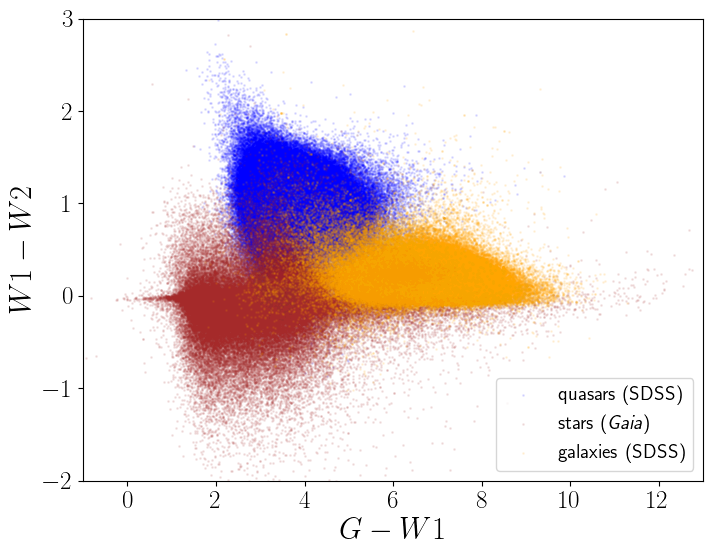

In [74]:
plt.figure(figsize=(8,6))
for i, tab in enumerate(tabs_labeled):
    plt.scatter(tab['phot_g_mean_mag']-tab['w1mpro'], tab['w1mpro']-tab['w2mpro'],
                color=colors[i], label=labels[i], alpha=0.1, s=1)
plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1, 13)
plt.ylim(-2, 3)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

Text(0, 0.5, '$G$')

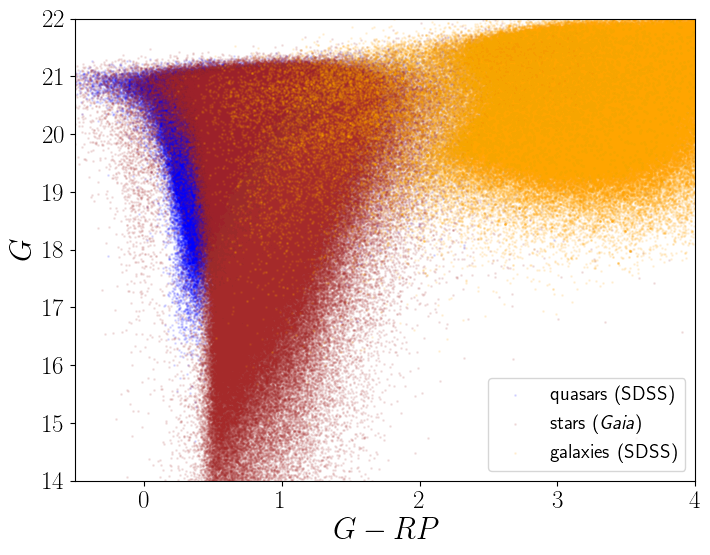

In [75]:
plt.figure(figsize=(8,6))
for i, tab in enumerate(tabs_labeled):
    plt.scatter(tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'], tab['phot_g_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.1, s=1)
plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-0.5, 4)
plt.ylim(14, 22)

plt.xlabel(r'$G-RP$')
plt.ylabel(r'$G$')

Text(0, 0.5, '$G-RP$')

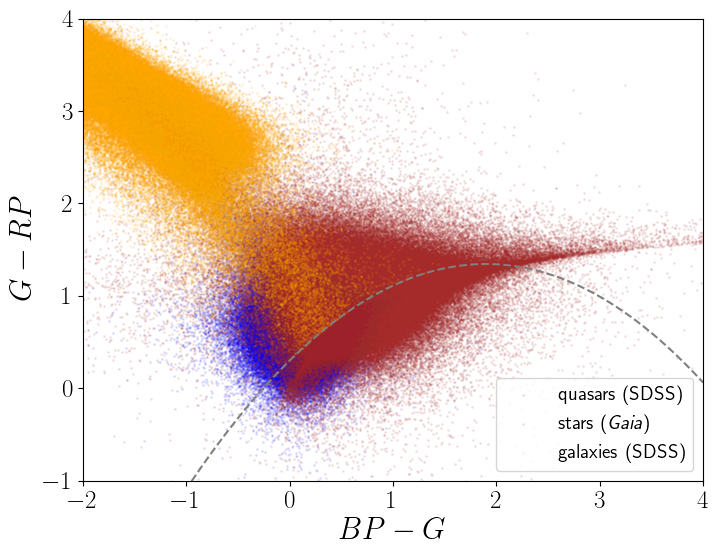

In [76]:
plt.figure(figsize=(8,6))
for i, tab in enumerate(tabs_labeled):
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'], 
                color=colors[i], label=labels[i], alpha=0.1, s=1)
plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-2, 4)
plt.ylim(-1, 4)

ax = plt.gca()
BP_G = np.linspace(*ax.get_xlim(), 100)
print()
f_G_RP = 0.3 + 1.1*(BP_G) - 0.29*(BP_G)**2
#f_G_RP = (2.3 + 1.1*(BP_G) - 0.4*(BP_G)**2)
plt.plot(BP_G, f_G_RP, color='grey', ls='--')

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-RP$')

## make train and validation samples

In [25]:
f_train = 0.7

In [26]:
tab_sdss['class'] = 'q'
tab_stars['class'] = 's'
tab_gals['class'] = 'g'

In [27]:
cols_tokeep = ['source_id', 'class', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
               'w1mpro', 'w2mpro']
tab_sdss_lite = tab_sdss.copy()
tab_stars_lite = tab_stars.copy()
tab_gals_lite = tab_gals.copy()

tab_sdss_lite.keep_columns(cols_tokeep)
tab_stars_lite.keep_columns(cols_tokeep)
tab_gals_lite.keep_columns(cols_tokeep)

In [28]:
len(tab_sdss_lite), len(tab_stars_lite), len(tab_gals_lite)

(379741, 720000, 775889)

In [29]:
tab_labeled = astropy.table.vstack([tab_sdss_lite, tab_stars_lite, tab_gals_lite], metadata_conflicts='silent')

In [30]:
print(len(tab_labeled))
print(tab_labeled.columns)

1875630
<TableColumns names=('source_id','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','w1mpro','w2mpro','class')>


In [31]:
source_ids = np.array(tab_labeled['source_id'])
classes = np.array(tab_labeled['class'])

In [32]:
N_labeled = len(classes)
print(N_labeled)

1875630


In [33]:
rand_ints = rng.choice(np.arange(N_labeled), size=N_labeled, replace=False)
i_train = rand_ints < int(f_train*N_labeled)
i_valid = ~i_train

In [34]:
np.sum(i_train), np.sum(i_valid)

(1312941, 562689)

In [35]:
source_ids_train = source_ids[i_train]
source_ids_valid = source_ids[i_valid]

classes_train = classes[i_train]
classes_valid = classes[i_valid]

In [36]:
class_nums = [np.sum(classes_valid==c) for c in class_labels]
class_fracs = class_nums/np.sum(class_nums)
print(class_fracs)

[0.2035014  0.38280293 0.41369566]


In [37]:
len(classes_valid), np.sum(classes_valid=='q'), np.sum(classes_valid=='s'), np.sum(classes_valid=='g')

(562689, 114508, 215399, 232782)

TODO: remove duplicates in multiple classes

## get class predictions of sample from source ids

In [38]:
# assumes all s_ids_pred_target are in target class (bc we're labeling all of our catalog 'quasars')
def get_classes(s_ids_pred_target, s_ids_valid, c_valid, target='q'):
    s_ids_pred_target = np.array(s_ids_pred_target)
    # Get which sources in validation set are in the predicted catalog
    i_in_pred = np.isin(s_ids_valid, s_ids_pred_target)
    # The predicted catalog is all targets; non-targets are other ('o')
    # okay making them all stars for now, dont know what to do when have gals too??
    c_pred = np.full(len(c_valid), 's')
    c_pred[i_in_pred] = target
    return c_pred

In [39]:
c_pred_gaia_all = get_classes(tab_gaia_all['source_id'], source_ids_valid, classes_valid)

In [40]:
c_pred_gaia_purer = get_classes(tab_gaia_purer['source_id'], source_ids_valid, classes_valid)

In [41]:
c_pred_gaia_nec = get_classes(tab_gaia_nec['source_id'], source_ids_valid, classes_valid)

In [42]:
c_pred_clean = get_classes(tab_clean['source_id'], source_ids_valid, classes_valid)

In [43]:
c_pred_Glim = get_classes(tab_Glim['source_id'], source_ids_valid, classes_valid)

In [44]:
c_pred_Gclean = get_classes(tab_Gclean['source_id'], source_ids_valid, classes_valid)

purity = TP/(TP+FP) = TP/allP

completeness = TP/(TP+FN) 

In [45]:
def confusion_matrix_binary(C_pred, C_true, target=1):
    TP = np.sum((C_pred==C_true) & (C_pred==target))
    FP = np.sum((C_pred==target) & (C_true!=target))
    FN = np.sum((C_pred!=target) & (C_true==target))
    TN = np.sum((C_pred==C_true) & (C_pred!=target))
    assert TP+FP == np.sum(C_pred==target)  
    assert TP+FN == np.sum(C_true==target)
    conf_mat = np.array([[TP, FP], [FN, TN]])

In [46]:
def confusion_matrix(C_pred, C_true, labels, priors=None, class_fracs=None):
    
    N_classes = len(labels)
    conf_mat = np.empty((N_classes, N_classes))
    for i in range(N_classes):
        for j in range(N_classes):
            conf_mat[i, j] = np.sum((C_true==labels[i]) & (C_pred==labels[j]))
    
    if priors is not None and class_fracs is None:
        assert len(priors)==N_classes
        priors_norm = priors/np.sum(priors)
        for i in range(N_classes):
            conf_mat[i] *= priors_norm[i]
    
    if class_fracs is not None:
        assert len(class_fracs)==N_classes
        if priors is None:
            priors = np.ones(N_classes)
        priors_norm = priors/np.sum(priors)      
        class_fracs_norm = class_fracs/np.sum(class_fracs)
        
        denominator = np.sum(priors_norm/class_fracs_norm)
        lambdas = priors_norm/class_fracs_norm * 1/denominator
        for i in range(N_classes):
            conf_mat[i] *= lambdas[i]   
    
    return conf_mat

In [54]:
def N_FP(conf_mat, label='q'):
    i = class_labels.index(label)
    FP = np.sum([conf_mat[j,i] for j in range(len(class_labels)) if j!=i])
    return FP

In [60]:
def N_FN(conf_mat, label='q'):
    i = class_labels.index(label)
    FN = np.sum([conf_mat[i,j] for j in range(len(class_labels)) if j!=i])
    return FN

In [47]:
def purity(conf_mat, label='q'):
    i = class_labels.index(label)
    TP = conf_mat[i,i]
    FP = np.sum([conf_mat[j,i] for j in range(len(class_labels)) if j!=i])
    return TP/(TP+FP)

In [48]:
def completeness(conf_mat, label='q'):
    i = class_labels.index(label)
    TP = conf_mat[i,i]
    FN = np.sum([conf_mat[i,j] for j in range(len(class_labels)) if j!=i])
    return TP/(TP+FN)

In [49]:
conf_mat_gaia_all_raw = confusion_matrix(c_pred_gaia_all, classes_valid, class_labels)
print(conf_mat_gaia_all_raw)

conf_mat_gaia_purer_raw = confusion_matrix(c_pred_gaia_purer, classes_valid, class_labels)
print(conf_mat_gaia_purer_raw)

conf_mat_clean_raw = confusion_matrix(c_pred_clean, classes_valid, class_labels)
print(conf_mat_clean_raw)

conf_mat_Glim_raw = confusion_matrix(c_pred_Glim, classes_valid, class_labels)
print(conf_mat_Glim_raw)

conf_mat_Gclean_raw = confusion_matrix(c_pred_Gclean, classes_valid, class_labels)
print(conf_mat_Gclean_raw)

[[ 98386.  16122.      0.]
 [   828. 214571.      0.]
 [  1602. 231180.      0.]]
[[9.65190e+04 1.79890e+04 0.00000e+00]
 [2.27000e+02 2.15172e+05 0.00000e+00]
 [9.12000e+02 2.31870e+05 0.00000e+00]]
[[7.66800e+04 3.78280e+04 0.00000e+00]
 [1.87000e+02 2.15212e+05 0.00000e+00]
 [5.76000e+02 2.32206e+05 0.00000e+00]]
[[5.27080e+04 6.18000e+04 0.00000e+00]
 [1.27000e+02 2.15272e+05 0.00000e+00]
 [3.02000e+02 2.32480e+05 0.00000e+00]]
[[3.32160e+04 8.12920e+04 0.00000e+00]
 [8.30000e+01 2.15316e+05 0.00000e+00]
 [2.13000e+02 2.32569e+05 0.00000e+00]]


In [54]:
purity(conf_mat_gaia_all_raw), purity(conf_mat_gaia_purer_raw), purity(conf_mat_clean_raw)

(0.9758966830661799, 0.9883368490036658, 0.9901475924228142)

In [55]:
completeness(conf_mat_gaia_all_raw), completeness(conf_mat_gaia_purer_raw), completeness(conf_mat_clean_raw)

(0.8592063436615782, 0.8429018059873546, 0.6696475355433682)

In [56]:
conf_mat_gaia_all = confusion_matrix(c_pred_gaia_all, classes_valid, class_labels, 
                                     priors=priors, class_fracs=class_fracs)
print(conf_mat_gaia_all)

[[3.68711730e+02 6.04188655e+01 0.00000000e+00]
 [8.24795224e+02 2.13740502e+05 0.00000000e+00]
 [1.96884414e-01 2.84118219e+01 0.00000000e+00]]


In [57]:
conf_mat_gaia_purer = confusion_matrix(c_pred_gaia_purer, classes_valid, class_labels, 
                                     priors=priors, class_fracs=class_fracs)
print(conf_mat_gaia_purer)

[[3.61714954e+02 6.74156415e+01 0.00000000e+00]
 [2.26121396e+02 2.14339176e+05 0.00000000e+00]
 [1.12084011e-01 2.84966223e+01 0.00000000e+00]]


In [58]:
conf_mat_gaia_nec = confusion_matrix(c_pred_gaia_nec, classes_valid, class_labels, 
                                     priors=priors, class_fracs=class_fracs)
print(conf_mat_gaia_nec)

[[2.89539856e+02 1.39590740e+02 0.00000000e+00]
 [2.01218158e+02 2.14364079e+05 0.00000000e+00]
 [8.29569158e-02 2.85257494e+01 0.00000000e+00]]


In [60]:
conf_mat_clean = confusion_matrix(c_pred_clean, classes_valid, class_labels, 
                                     priors=priors, class_fracs=class_fracs)
print(conf_mat_clean)

[[2.87366245e+02 1.41764350e+02 0.00000000e+00]
 [1.86276216e+02 2.14379021e+05 0.00000000e+00]
 [7.07899015e-02 2.85379164e+01 0.00000000e+00]]


In [61]:
purity(conf_mat_gaia_all), purity(conf_mat_gaia_purer), purity(conf_mat_gaia_nec), purity(conf_mat_clean)

(0.3088804089892728,
 0.6152154390118827,
 0.5898852636971308,
 0.6066248825586033)

In [62]:
completeness(conf_mat_gaia_all), completeness(conf_mat_gaia_purer), completeness(conf_mat_gaia_nec), completeness(conf_mat_clean)

(0.8592063436615782,
 0.8429018059873546,
 0.6747126838299508,
 0.6696475355433682)

## Plot results

In [195]:
i_q_gaia_all = np.isin(tab_gaia_all['source_id'], source_ids_valid[classes_valid=='q'])
i_notq_gaia_all = np.isin(tab_gaia_all['source_id'], source_ids_valid[classes_valid!='q'])

i_valid_notq_gaia_all = (c_pred_gaia_all!='q') & (classes_valid=='q')
#np.isin(source_id_valid[classes_valid=='q'], tab_clean['source_id'])

0.9764385863151789
0.8581674357284114


Text(0, 0.5, '$W1-W2$')

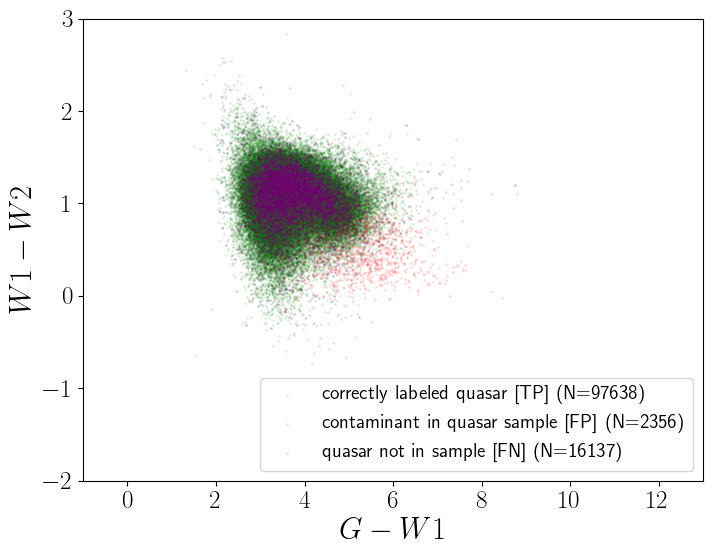

In [208]:
tabs = [tab_gaia_all[i_q_gaia_all], tab_gaia_all[i_notq_gaia_all], tab_labeled[i_valid][i_valid_notq_gaia_all]]
colors = ['green', 'red', 'purple']
labels = ['correctly labeled quasar [TP]', 'contaminant in quasar sample [FP]', 'quasar not in sample [FN]']

#print(len(tabs[0])/(len(tabs[0])+len(tabs[1])))
print(len(tabs[0])/(len(tabs[0])+len(tabs[2])))

plt.figure(figsize=(8,6))
for i, tab in enumerate(tabs):
    N = len(tab)
    label = labels[i] + f' (N={N})'
    plt.scatter(tab['phot_g_mean_mag']-tab['w1mpro'], tab['w1mpro']-tab['w2mpro'],
                color=colors[i], label=label, alpha=0.1, s=1)
plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1, 13)
plt.ylim(-2, 3)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

In [204]:
i_sdss_in_gaia = np.isin(tab_sdss['source_id'], tab_gaia_all['source_id'])
print(np.sum(i_sdss_in_gaia))
print(np.sum(i_sdss_in_gaia)/len(i_sdss_in_gaia))

326086
0.8587063287872524


In [162]:
i_q_clean = np.isin(tab_clean['source_id'], source_ids_valid[classes_valid=='q'])
i_notq_clean = np.isin(tab_clean['source_id'], source_ids_valid[classes_valid!='q'])

i_valid_notq_clean = (c_pred_clean!='q') & (classes_valid=='q')

#np.isin(source_id_valid[classes_valid=='q'], tab_clean['source_id'])

Text(0, 0.5, '$W1-W2$')

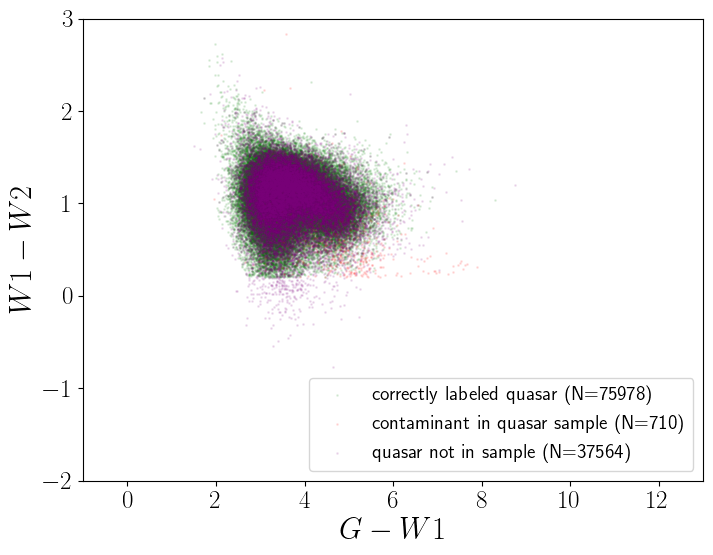

In [194]:
tabs = [tab_clean[i_q_clean], tab_clean[i_notq_clean], tab_labeled[i_valid][i_valid_notq_clean]]
colors = ['green', 'red', 'purple']
labels = ['correctly labeled quasar', 'contaminant in quasar sample', 'quasar not in sample']

plt.figure(figsize=(8,6))
for i, tab in enumerate(tabs):
    N = len(tab)
    label = labels[i] + f' (N={N})'
    plt.scatter(tab['phot_g_mean_mag']-tab['w1mpro'], tab['w1mpro']-tab['w2mpro'],
                color=colors[i], label=label, alpha=0.1, s=1)
plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1, 13)
plt.ylim(-2, 3)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

In [221]:
np.sum((tab_sdss['wa1mpro'] - tab_sdss['w2mpro']) < 0.29)

4038

In [222]:
i_gaia_all_in_clean = np.isin(tab_gaia_all['source_id'], tab_clean['source_id'])
print(np.sum(i_gaia_all_in_clean))
i_q_ingaia_clean = i_q_gaia_all & i_gaia_all_in_clean
print(np.sum(i_q_clean))
i_q_ingaia_notinclean = i_q_gaia_all & ~i_gaia_all_in_clean
print(np.sum(i_q_ingaia_notinclean))

1451214
75978
21454


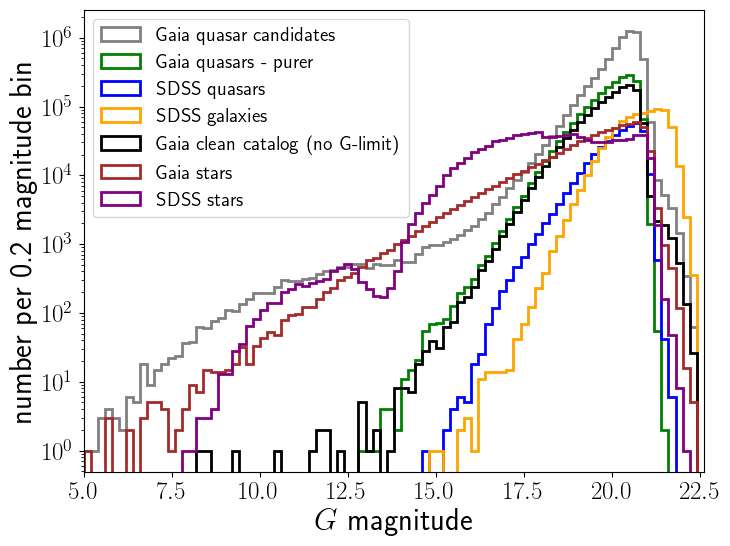

In [28]:
xlim = 5, 22.6
plt.figure(figsize=(8,6))
g_bins = np.arange(xlim[0], xlim[1], 0.2)

tabs = [tab_gaia_all, tab_gaia_purer, tab_sdss, tab_gals, tab_clean, tab_stars, tab_stars_sdss]
colors = ['grey', 'green', 'blue', 'orange', 'black', 'brown', 'purple']
labels = ['Gaia quasar candidates', 'Gaia quasars - purer', 'SDSS quasars', 
          'SDSS galaxies', 'Gaia clean catalog (no G-limit)', 'Gaia stars', 'SDSS stars']
for i in range(len(tabs)):
    plt.hist(tabs[i]['phot_g_mean_mag'], histtype='step', cumulative=False, 
             bins=g_bins, color=colors[i], lw=2, label=labels[i])

plt.yscale('log')
plt.xlim(xlim)

plt.xlabel(r'$G$ magnitude')
plt.ylabel('number per 0.2 magnitude bin')

plt.legend(loc='upper left', fontsize=14)

todo - what bailer-jones et al do and limit to G<20.75 for SDSS!

# Compute relative values

In [50]:
c_pred_gaia_all = get_classes(tab_gaia_all['source_id'], source_ids, classes)

c_pred_gaia_purer = get_classes(tab_gaia_purer['source_id'], source_ids, classes)

c_pred_gaia_nec = get_classes(tab_gaia_nec['source_id'], source_ids, classes)

c_pred_clean = get_classes(tab_clean['source_id'], source_ids, classes)

c_pred_Glim = get_classes(tab_Glim['source_id'], source_ids, classes)

c_pred_Gclean = get_classes(tab_Gclean['source_id'], source_ids, classes)

In [70]:
len(tab_gaia_nec), len(tab_clean)

(1555108, 1451214)

In [51]:
print(len(c_pred_gaia_all))

1875630


In [65]:
conf_mat_gaia_all_raw = confusion_matrix(c_pred_gaia_all, classes, class_labels)
print(conf_mat_gaia_all_raw)

conf_mat_gaia_purer_raw = confusion_matrix(c_pred_gaia_purer, classes, class_labels)
print(conf_mat_gaia_purer_raw)

conf_mat_gaia_nec_raw = confusion_matrix(c_pred_gaia_nec, classes, class_labels)
print(conf_mat_gaia_nec_raw)

conf_mat_clean_raw = confusion_matrix(c_pred_clean, classes, class_labels)
print(conf_mat_clean_raw)

conf_mat_Glim_raw = confusion_matrix(c_pred_Glim, classes, class_labels)
print(conf_mat_Glim_raw)

conf_mat_Gclean_raw = confusion_matrix(c_pred_Gclean, classes, class_labels)
print(conf_mat_Gclean_raw)

[[326086.  53655.      0.]
 [  2666. 717334.      0.]
 [  5436. 770453.      0.]]
[[3.20039e+05 5.97020e+04 0.00000e+00]
 [7.58000e+02 7.19242e+05 0.00000e+00]
 [3.19000e+03 7.72699e+05 0.00000e+00]]
[[2.55906e+05 1.23835e+05 0.00000e+00]
 [6.12000e+02 7.19388e+05 0.00000e+00]
 [2.24000e+03 7.73649e+05 0.00000e+00]]
[[2.54005e+05 1.25736e+05 0.00000e+00]
 [5.73000e+02 7.19427e+05 0.00000e+00]
 [1.91900e+03 7.73970e+05 0.00000e+00]]
[[1.74597e+05 2.05144e+05 0.00000e+00]
 [3.65000e+02 7.19635e+05 0.00000e+00]
 [9.88000e+02 7.74901e+05 0.00000e+00]]
[[1.09844e+05 2.69897e+05 0.00000e+00]
 [2.27000e+02 7.19773e+05 0.00000e+00]
 [6.66000e+02 7.75223e+05 0.00000e+00]]


In [71]:
# FP
fp_gaia_all = N_FP(conf_mat_gaia_all_raw, label='q')
print(fp_gaia_all)

fp_gaia_purer = N_FP(conf_mat_gaia_purer_raw, label='q')
print(fp_gaia_purer)
print(fp_gaia_all/fp_gaia_purer)

fp_gaia_nec = N_FP(conf_mat_gaia_nec_raw, label='q')
print(fp_gaia_nec)
print(fp_gaia_all/fp_gaia_nec)

fp_clean = N_FP(conf_mat_clean_raw, label='q')
print(fp_clean)
print(fp_gaia_all/fp_clean)

print(fp_gaia_nec/fp_clean)

8102.0
3948.0
2.052178318135765
2852.0
2.840813464235624
2492.0
3.251203852327448
1.14446227929374


In [68]:
# FN
fn_gaia_all = N_FN(conf_mat_gaia_all_raw, label='q')
print(fn_gaia_all)

fn_gaia_purer = N_FN(conf_mat_gaia_purer_raw, label='q')
print(fn_gaia_purer)

print(fn_gaia_all/fn_gaia_purer)

fn_gaia_nec = N_FN(conf_mat_gaia_nec_raw, label='q')
print(fn_gaia_nec)
print(fn_gaia_all/fn_gaia_nec)

fn_clean = N_FN(conf_mat_clean_raw, label='q')
print(fn_clean)
print(fn_gaia_all/fn_clean)

53655.0
59702.0
0.898713610934307
123835.0
0.4332781523801833
125736.0
0.4267274288986448


In [69]:
# FP
comp_gaia_all = completeness(conf_mat_gaia_all_raw, label='q')
print(comp_gaia_all)

comp_gaia_purer = completeness(conf_mat_gaia_purer_raw, label='q')
print(comp_gaia_purer)
print((comp_gaia_purer-comp_gaia_all)/comp_gaia_all)

comp_gaia_nec = completeness(conf_mat_gaia_nec_raw, label='q')
print(comp_gaia_nec)
print((comp_gaia_nec-comp_gaia_all)/comp_gaia_all)

comp_clean = completeness(conf_mat_clean_raw, label='q')
print(comp_clean)
print((comp_clean-comp_gaia_all)/comp_gaia_all)


0.8587063287872524
0.842782317421611
-0.018544187729617394
0.6738961555375901
-0.21521929797660744
0.6688901119447203
-0.221049048410542


In [74]:
tab_Gclean.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm','redshift_spz','redshift_sdss')>

## unWISE

In [5]:
fn_gaia_unwise = '../data/gaia_unwise_slim.fits'
tab_gaia_unwise = utils.load_table(fn_gaia_unwise)
N_data_unwise = len(tab_gaia_unwise)
print(f"Number of data sources: {N_data_unwise}")

Number of data sources: 6649162


In [6]:
tab_gaia_unwise.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','mag_w1_vg','mag_w2_vg','unwise_objid','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm')>

In [7]:
i_has_qsoc = np.isfinite(tab_gaia_unwise['redshift_qsoc'])
print(f'N with QSOC redshifts: {np.sum(i_has_qsoc)}')

N with QSOC redshifts: 6375063


In [13]:
col_names_necessary = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'mag_w1_vg', 'mag_w2_vg']
cols_necessary = []
for col_name in col_names_necessary:
    cols_necessary.append(tab_gaia_unwise[col_name])
cols_necessary = np.array(cols_necessary).T
i_has_necessary = np.all(np.isfinite(cols_necessary), axis=1)
print(f"Has necessary color data: {np.sum(i_has_necessary)} ({np.sum(i_has_necessary)/len(i_has_necessary):.3f})")

Has necessary color data: 1990559 (0.299)


In [10]:
print("Has QSOC and color:", np.sum(i_has_qsoc & i_has_necessary))

Has QSOC and color: 1814201


In [11]:
tab_gaia_nec = tab_gaia_all[i_has_qsoc & i_has_necessary]
print(len(tab_gaia_nec))

1814201


## catWISE

In [14]:
fn_gaia_unwise = '../data/gaia_catwise_slim.fits'
tab_gaia_unwise = utils.load_table(fn_gaia_unwise)
N_data_unwise = len(tab_gaia_unwise)
print(f"Number of data sources: {N_data_unwise}")

Number of data sources: 6649162


In [15]:
tab_gaia_unwise.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','w1mag','w2mag','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm')>

In [26]:
i_has_catwise = np.isfinite(tab_gaia_unwise['catwise_source_id'])
print(np.sum(i_has_catwise))

KeyError: 'catwise_source_id'

In [16]:
i_has_qsoc = np.isfinite(tab_gaia_unwise['redshift_qsoc'])
print(f'N with QSOC redshifts: {np.sum(i_has_qsoc)}')

N with QSOC redshifts: 6375063


In [23]:
col_names_necessary = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'w1mag', 'w2mag']
#col_names_necessary = ['w1mag', 'w2mag']
cols_necessary = []
for col_name in col_names_necessary:
    cols_necessary.append(tab_gaia_unwise[col_name])
cols_necessary = np.array(cols_necessary).T
i_has_necessary = np.all(np.isfinite(cols_necessary), axis=1)
print(f"Has necessary color data: {np.sum(i_has_necessary)} ({np.sum(i_has_necessary)/len(i_has_necessary):.3f})")

Has necessary color data: 2251232 (0.339)


In [24]:
print("Has QSOC and color:", np.sum(i_has_qsoc & i_has_necessary))

Has QSOC and color: 2061815


In [25]:
tab_gaia_nec = tab_gaia_all[i_has_qsoc & i_has_necessary]
print(len(tab_gaia_nec))

2061815
